# Antibiotic Consumption vs. E. coli Resistance Analysis

**Author:** [Your Name]  
**Date:** October 8, 2025

## Overview
This analysis investigates the relationship between antibiotic consumption and E. coli resistance patterns across countries. It explores:
1. Which antibiotics show the strongest correlation with human consumption
2. How resistance varies across different antibiotics and countries
3. The relationship between livestock antibiotic use and human bacterial resistance

---


## 1. Setup and Data Loading


In [114]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from adjustText import adjust_text
import warnings
warnings.filterwarnings('ignore')

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

print("✓ Libraries loaded successfully")


✓ Libraries loaded successfully


In [115]:
# Load datasets
print("Loading datasets...")

usage = pd.read_csv("/Users/anteaabilekaj/Documents/MAT2007/amu.csv", skiprows=17)
resistance = pd.read_csv("/Users/anteaabilekaj/Documents/MAT2007/resistance.csv", skiprows=42)
livestock = pd.read_csv("/Users/anteaabilekaj/Documents/MAT2007/antibiotic-usage-in-livestock/antibiotic-usage-in-livestock.csv")

print(f"✓ Human antibiotic usage: {len(usage)} records")
print(f"✓ Resistance data: {len(resistance)} records")
print(f"✓ Livestock usage: {len(livestock)} records")


Loading datasets...
✓ Human antibiotic usage: 65 records
✓ Resistance data: 879 records
✓ Livestock usage: 192 records


## 2. Data Preprocessing


In [116]:
# Clean human antibiotic usage data
usage_clean = usage[['CountryTerritoryArea', 'DID_antibiotics']].copy()
usage_clean.rename(columns={'CountryTerritoryArea': 'Country'}, inplace=True)
usage_clean['Country'] = usage_clean['Country'].str.strip()

print(f"Human usage data: {len(usage_clean)} countries")
usage_clean.head()


Human usage data: 65 countries


,Country,DID_antibiotics
0,Armenia,13.879191
1,Austria,11.742038
2,Belgium,20.929122
3,Benin,22.476341
4,Burkina Faso,20.238437


In [117]:
# Clean livestock antibiotic usage data
livestock_clean = livestock[['Entity', 'Antimicrobial usage in livestock (mg per population corrected units)']].copy()
livestock_clean.rename(columns={
    'Entity': 'Country',
    'Antimicrobial usage in livestock (mg per population corrected units)': 'Livestock_Usage'
}, inplace=True)
livestock_clean['Country'] = livestock_clean['Country'].str.strip()

print(f"Livestock usage data: {len(livestock_clean)} countries")
livestock_clean.head()


Livestock usage data: 192 countries


,Country,Livestock_Usage
0,Afghanistan,67.548805
1,Albania,98.164760
2,Algeria,32.773270
3,Angola,21.049955
4,Antigua and Barbuda,416.205050


In [118]:
# Standardize country names to handle encoding issues and variations
def standardize_country_name(name):
    """
    Standardize country names by:
    - Stripping whitespace
    - Replacing fancy apostrophes/quotes with standard ones
    - Normalizing Unicode characters
    """
    import unicodedata
    
    # Strip whitespace
    name = name.strip()
    
    # Replace various apostrophe/quote characters with standard ones
    name = name.replace(''', "'").replace(''', "'").replace('"', '"').replace('"', '"')
    
    # Normalize Unicode (e.g., Côte -> Cote if needed, but keep original for now)
    # name = unicodedata.normalize('NFKD', name).encode('ASCII', 'ignore').decode('ASCII')
    
    return name

# Apply standardization to all datasets
usage_clean['Country'] = usage_clean['Country'].apply(standardize_country_name)
livestock_clean['Country'] = livestock_clean['Country'].apply(standardize_country_name)
resistance['CountryTerritoryArea'] = resistance['CountryTerritoryArea'].apply(standardize_country_name)

print("✓ Country names standardized across all datasets")
print(f"  Example fixes: fancy apostrophes (') → standard apostrophes (')")


✓ Country names standardized across all datasets
  Example fixes: fancy apostrophes (') → standard apostrophes (')


In [119]:
# Filter for E. coli bloodstream infections
ecoli_data = resistance[
    (resistance['PathogenName'].str.contains('Escherichia coli', case=False, na=False)) &
    (resistance['Specimen'].str.contains('Bloodstream', case=False, na=False))
].copy()

print(f"E. coli resistance records: {len(ecoli_data)}")
print(f"\nAntibiotics tested: {ecoli_data['AntibioticName'].nunique()}")
print(f"Countries: {ecoli_data['CountryTerritoryArea'].nunique()}")


E. coli resistance records: 879

Antibiotics tested: 14
Countries: 93


## 3. Finding Top Antibiotics by Correlation

We test all antibiotics to find which ones show the strongest correlation between human consumption and E. coli resistance.


In [120]:
# Analyze correlation for each antibiotic
antibiotics = ecoli_data['AntibioticName'].unique()
results = []

for antibiotic in antibiotics:
    resistance_ab = ecoli_data[
        ecoli_data['AntibioticName'] == antibiotic
    ][['CountryTerritoryArea', 'ResistancePercentage']].copy()
    
    resistance_ab.rename(columns={'CountryTerritoryArea': 'Country'}, inplace=True)
    resistance_ab['Country'] = resistance_ab['Country'].str.strip()
    
    merged = pd.merge(usage_clean, resistance_ab, on='Country', how='inner')
    
    if len(merged) >= 10:
        r_value, p_value = pearsonr(merged['DID_antibiotics'], merged['ResistancePercentage'])
        r_squared = r_value ** 2
        
        results.append({
            'Antibiotic': antibiotic,
            'Countries': len(merged),
            'r': r_value,
            'R²': r_squared,
            'p-value': p_value,
            'Significant': 'Yes' if p_value < 0.05 else 'No',
            'data': merged
        })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('R²', ascending=False)

# Display top 10
print("Top 10 Antibiotics by R² (Coefficient of Determination):\n")
results_df[['Antibiotic', 'Countries', 'r', 'R²', 'p-value', 'Significant']].head(10)


Top 10 Antibiotics by R² (Coefficient of Determination):



,Antibiotic,Countries,r,R²,p-value,Significant
8,Imipenem,45,0.424684,0.180357,0.003641,Yes
1,Cefotaxime,40,0.419847,0.176271,0.006996,Yes
3,Ceftriaxone,42,0.376868,0.142029,0.013888,Yes
11,Third generation cephalosporins resistance,51,0.367670,0.135181,0.007948,Yes
4,Ciprofloxacin,51,0.351810,0.123770,0.011353,Yes
2,Ceftazidime,46,0.348553,0.121489,0.017600,Yes
0,Cefepime,39,0.298171,0.088906,0.065230,No
10,Meropenem,49,0.281404,0.079188,0.050141,No
9,Levofloxacin,30,0.208564,0.043499,0.268713,No
6,Colistin,25,-0.203838,0.041550,0.328408,No


In [ ]:
# Get top 2 for visualization
top2 = results_df.head(2)

print("Top 2 Antibiotics Selected for Detailed Analysis:\n")
for idx, row in top2.iterrows():
    print(f"{idx+1}. {row['Antibiotic']}")
    print(f"   - Pearson r: {row['r']:.3f}")
    print(f"   - R²: {row['R²']:.3f} ({row['R²']*100:.1f}% of variance explained)")
    print(f"   - p-value: {row['p-value']:.4f}")
    print(f"   - Countries: {row['Countries']}\n")


Top 2 Antibiotics Selected for Detailed Analysis:

9. Imipenem
   - Pearson r: 0.425
   - R²: 0.180 (18.0% of variance explained)
   - p-value: 0.0036
   - Countries: 45

2. Cefotaxime
   - Pearson r: 0.420
   - R²: 0.176 (17.6% of variance explained)
   - p-value: 0.0070
   - Countries: 40



## 4. Visualization 1: Top 2 Antibiotic Correlations

Detailed scatter plots showing the relationship between human antibiotic consumption and E. coli resistance for the two antibiotics with the strongest correlations.


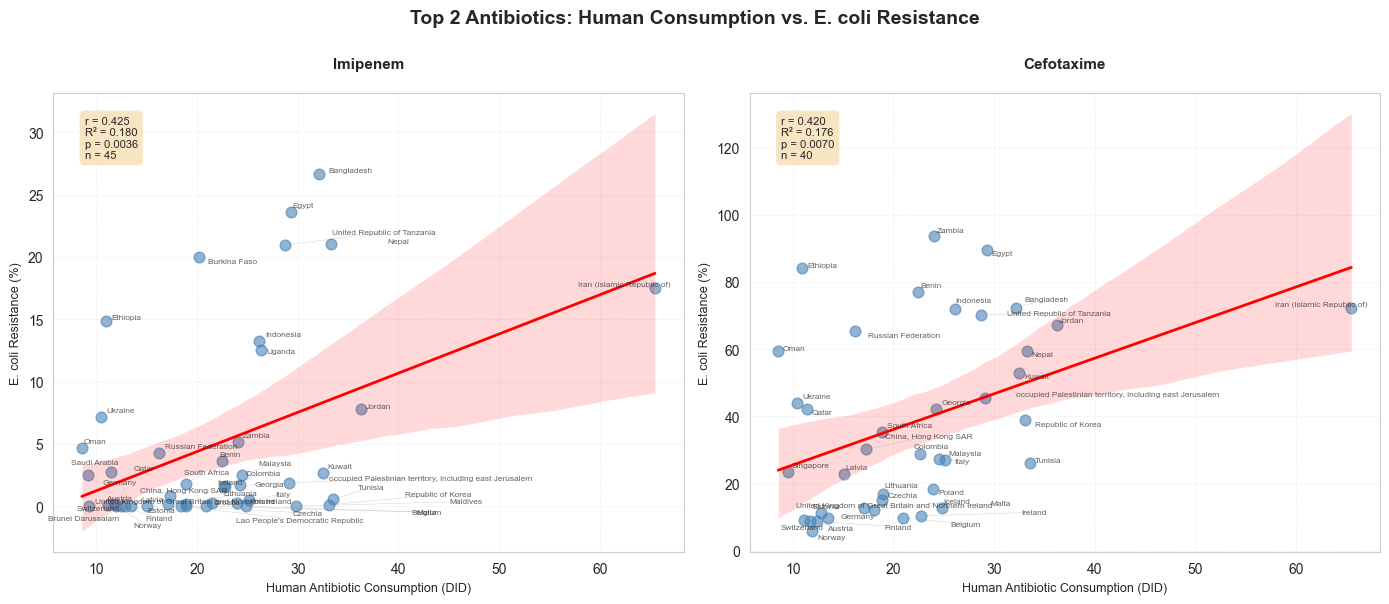

✓ Figure saved as: outputs/figures/1_top2_antibiotics_with_countries.png


In [122]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for idx, (_, row) in enumerate(top2.iterrows()):
    ax = axes[idx]
    merged = row['data']
    
    # Scatter plot with regression line
    sns.regplot(
        data=merged,
        x='DID_antibiotics',
        y='ResistancePercentage',
        scatter_kws={'s': 60, 'alpha': 0.6, 'color': 'steelblue'},
        line_kws={'color': 'red', 'linewidth': 2},
        ax=ax
    )
    
    # Add country labels
    texts = []
    for _, country_row in merged.iterrows():
        text = ax.annotate(
            country_row['Country'],
            (country_row['DID_antibiotics'], country_row['ResistancePercentage']),
            fontsize=6,
            alpha=0.7
        )
        texts.append(text)
    
    # Adjust text positions to avoid overlaps
    adjust_text(texts, 
                arrowprops=dict(arrowstyle='-', color='gray', lw=0.3, alpha=0.4, shrinkA=3, shrinkB=3),
                expand_points=(1.3, 1.3),
                ax=ax)
    
    # Formatting
    antibiotic_name = row['Antibiotic']
    if len(antibiotic_name) > 30:
        antibiotic_name = antibiotic_name[:27] + "..."
    
    ax.set_title(f"{antibiotic_name}\n", fontsize=11, fontweight='bold')
    ax.set_xlabel('Human Antibiotic Consumption (DID)', fontsize=9)
    ax.set_ylabel('E. coli Resistance (%)', fontsize=9)
    ax.grid(alpha=0.3, linestyle='--', linewidth=0.5)
    
    # Statistics box
    stats_text = f"r = {row['r']:.3f}\nR² = {row['R²']:.3f}\np = {row['p-value']:.4f}\nn = {row['Countries']}"
    ax.text(0.05, 0.95, stats_text,
            transform=ax.transAxes,
            fontsize=8,
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8, pad=0.5))

plt.suptitle('Top 2 Antibiotics: Human Consumption vs. E. coli Resistance', 
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig("outputs/figures/1_top2_antibiotics_with_countries.png", dpi=300, bbox_inches='tight')
plt.show()

print("✓ Figure saved as: outputs/figures/1_top2_antibiotics_with_countries.png")


## 5. Visualization 2: Distribution of Resistance Across Countries

Box plots showing how E. coli resistance varies across countries for different antibiotics.


In [123]:
# Include ALL antibiotics from the dataset, organized by class
# Define antibiotic classes with color mapping
antibiotic_classes = {
    # Penicillins (older, broad-spectrum)
    'Ampicillin': ('Penicillins', '#e74c3c'),
    
    # Cephalosporins - 3rd generation
    'Cefotaxime': ('Cephalosporins (3rd gen)', '#3498db'),
    'Ceftazidime': ('Cephalosporins (3rd gen)', '#3498db'),
    'Ceftriaxone': ('Cephalosporins (3rd gen)', '#3498db'),
    'Third generation cephalosporins resistance': ('Cephalosporins (3rd gen)', '#3498db'),
    
    # Cephalosporins - 4th generation
    'Cefepime': ('Cephalosporins (4th gen)', '#5dade2'),
    
    # Fluoroquinolones
    'Ciprofloxacin': ('Fluoroquinolones', '#f39c12'),
    'Levofloxacin': ('Fluoroquinolones', '#f39c12'),
    
    # Folate pathway inhibitors
    'Co-trimoxazole': ('Folate inhibitors', '#9b59b6'),
    
    # Carbapenems (last-resort)
    'Doripenem': ('Carbapenems', '#2ecc71'),
    'Ertapenem': ('Carbapenems', '#2ecc71'),
    'Imipenem': ('Carbapenems', '#2ecc71'),
    'Meropenem': ('Carbapenems', '#2ecc71'),
    
    # Polymyxins (last-resort)
    'Colistin': ('Polymyxins', '#e67e22'),
}

# Get all antibiotics
all_antibiotics = list(antibiotic_classes.keys())

filtered_data = ecoli_data[ecoli_data['AntibioticName'].isin(all_antibiotics)].copy()

pivot_data = filtered_data.pivot_table(
    index='CountryTerritoryArea',
    columns='AntibioticName',
    values='ResistancePercentage',
    aggfunc='mean'
)

# Reorder by average resistance
col_order = pivot_data.mean().sort_values(ascending=False).index
pivot_data = pivot_data[col_order]

print(f"Analyzing {len(all_antibiotics)} antibiotics across {len(pivot_data)} countries\n")
print("Average resistance by antibiotic:")
print(pivot_data.mean().sort_values(ascending=False))
print(f"\nAntibiotic classes represented: {len(set([v[0] for v in antibiotic_classes.values()]))}")


Analyzing 14 antibiotics across 93 countries

Average resistance by antibiotic:
AntibioticName
Ampicillin                                    63.974405
Co-trimoxazole                                59.935813
Ceftriaxone                                   48.409046
Third generation cephalosporins resistance    46.150380
Cefotaxime                                    45.197127
Ciprofloxacin                                 44.826517
Levofloxacin                                  43.463804
Ceftazidime                                   37.117492
Cefepime                                      36.980574
Ertapenem                                      6.437537
Imipenem                                       6.287321
Meropenem                                      5.933546
Colistin                                       5.160218
Doripenem                                      3.346628
dtype: float64

Antibiotic classes represented: 7


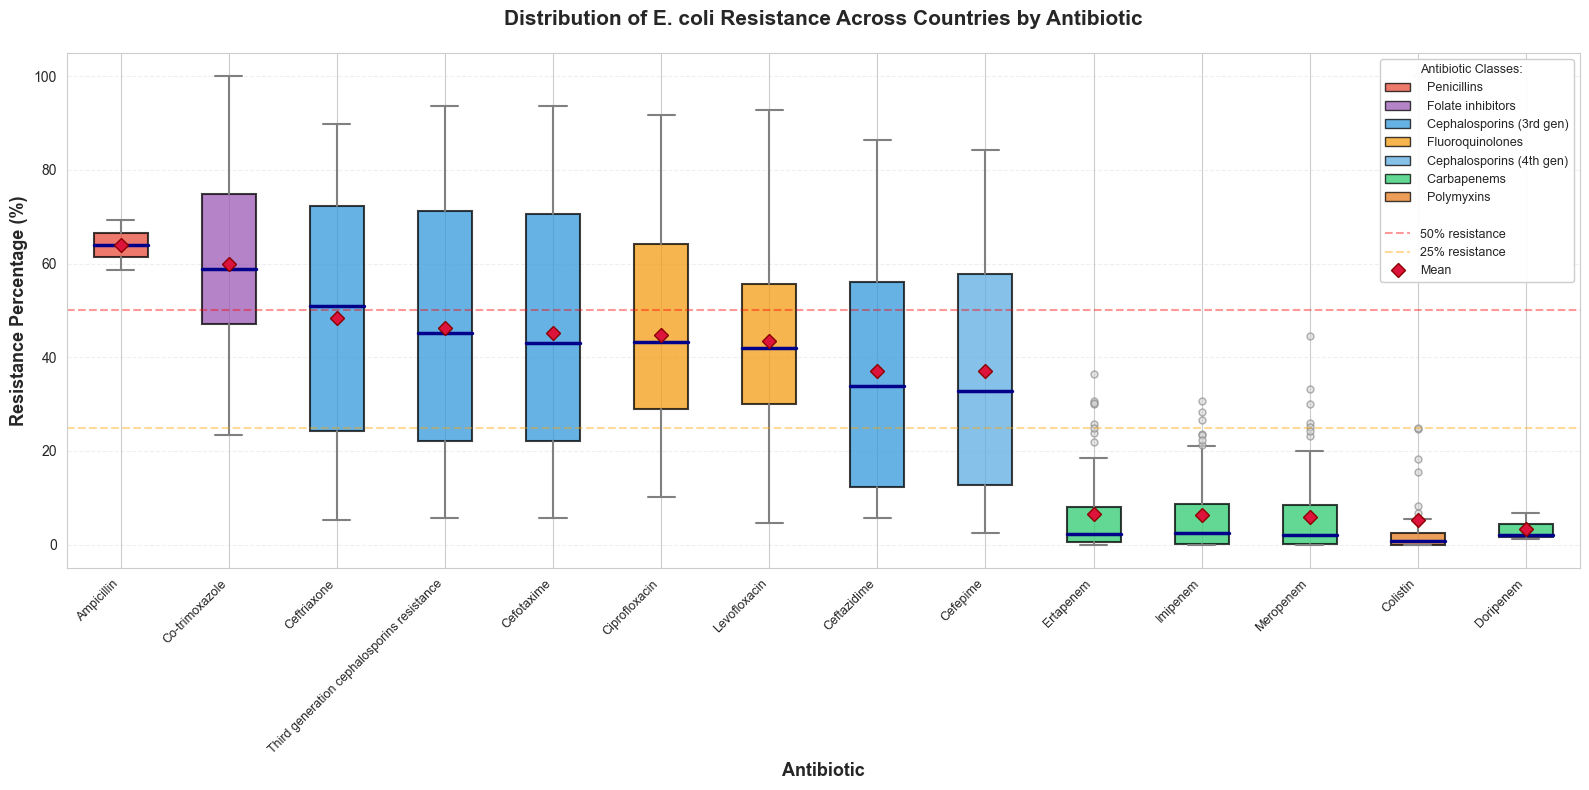

✓ Figure saved as: outputs/figures/2_antibiotic_resistance_distribution.png
✓ All 14 antibiotics included, grouped into 7 classes


In [124]:
fig, ax = plt.subplots(figsize=(16, 8))

# Create box plot
bp = pivot_data.boxplot(
    ax=ax, rot=45, patch_artist=True, showmeans=True,
    meanprops=dict(marker='D', markerfacecolor='crimson', markersize=7, markeredgecolor='darkred', markeredgewidth=1),
    medianprops=dict(color='darkblue', linewidth=2.5),
    whiskerprops=dict(linewidth=1.5, color='gray'), 
    capprops=dict(linewidth=1.5, color='gray'),
    flierprops=dict(marker='o', markerfacecolor='lightgray', markersize=5, alpha=0.6, markeredgecolor='gray')
)

# Color each box by antibiotic class
for i, column in enumerate(pivot_data.columns):
    if column in antibiotic_classes:
        class_name, color = antibiotic_classes[column]
        box = bp.findobj(lambda x: hasattr(x, 'get_label') and x.get_label() == column)
        
        # Find the box patch (there should be one per antibiotic)
        patches = [patch for patch in ax.patches if isinstance(patch, plt.matplotlib.patches.PathPatch)]
        if i < len(patches):
            patches[i].set_facecolor(color)
            patches[i].set_alpha(0.75)
            patches[i].set_edgecolor('black')
            patches[i].set_linewidth(1.5)

ax.set_title('Distribution of E. coli Resistance Across Countries by Antibiotic', #(Color coded by antibiotic class, sorted by average resistance
          fontsize=15, fontweight='bold', pad=20)
ax.set_ylabel('Resistance Percentage (%)', fontsize=13, fontweight='bold')
ax.set_xlabel('Antibiotic', fontsize=13, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=9)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_ylim(-5, 105)

# Reference lines
ax.axhline(y=50, color='red', linestyle='--', alpha=0.4, linewidth=1.5, label='50% resistance')
ax.axhline(y=25, color='orange', linestyle='--', alpha=0.4, linewidth=1.5, label='25% resistance')

# Create legend with antibiotic classes
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# Get unique classes in order
unique_classes = []
seen = set()
for antibiotic in pivot_data.columns:
    if antibiotic in antibiotic_classes:
        class_name, color = antibiotic_classes[antibiotic]
        if class_name not in seen:
            unique_classes.append((class_name, color))
            seen.add(class_name)

legend_elements = []

# Add antibiotic class colors
legend_elements.append(Line2D([0], [0], color='none', label='Antibiotic Classes:', linewidth=0))
for class_name, color in unique_classes:
    legend_elements.append(Patch(facecolor=color, edgecolor='black', alpha=0.75, label=f'  {class_name}'))

# Add separator and statistics
legend_elements.append(Line2D([0], [0], color='none', label='', linewidth=0))
legend_elements.append(Line2D([0], [0], color='red', linestyle='--', alpha=0.4, linewidth=1.5, label='50% resistance'))
legend_elements.append(Line2D([0], [0], color='orange', linestyle='--', alpha=0.4, linewidth=1.5, label='25% resistance'))
legend_elements.append(Line2D([0], [0], marker='D', color='w', markerfacecolor='crimson', 
                              markersize=7, markeredgecolor='darkred', markeredgewidth=1, label='Mean'))

ax.legend(handles=legend_elements, loc='upper right', fontsize=9, framealpha=0.95)

plt.tight_layout()
plt.savefig("outputs/figures/2_antibiotic_resistance_distribution.png", dpi=300, bbox_inches='tight')
plt.show()

print("✓ Figure saved as: outputs/figures/2_antibiotic_resistance_distribution.png")
print(f"✓ All {len(all_antibiotics)} antibiotics included, grouped into {len(unique_classes)} classes")


## 6. Visualization 3: Livestock vs Human Resistance

Exploring whether livestock antibiotic usage correlates with human E. coli resistance patterns. Using Ciprofloxacin, a widely-used fluoroquinolone antibiotic.


In [125]:
# Get Ciprofloxacin resistance data
resistance_ecoli = ecoli_data[
    ecoli_data['AntibioticName'] == 'Ciprofloxacin'
][['CountryTerritoryArea', 'ResistancePercentage']].copy()

resistance_clean = resistance_ecoli.rename(columns={'CountryTerritoryArea': 'Country'})
resistance_clean['Country'] = resistance_clean['Country'].str.strip()

# Merge with livestock data
merged_livestock = pd.merge(livestock_clean, resistance_clean, on='Country', how='inner')

# Calculate correlation
r_value, p_value = pearsonr(merged_livestock['Livestock_Usage'], merged_livestock['ResistancePercentage'])
r_squared = r_value ** 2

print(f"Livestock vs Human Resistance Correlation:")
print(f"  - Countries analyzed: {len(merged_livestock)}")
print(f"  - Pearson r: {r_value:.3f}")
print(f"  - R²: {r_squared:.3f} ({r_squared*100:.1f}% of variance explained)")
print(f"  - p-value: {p_value:.4f}")
print(f"  - Statistically significant: {'Yes' if p_value < 0.05 else 'No'}")


Livestock vs Human Resistance Correlation:
  - Countries analyzed: 75
  - Pearson r: 0.152
  - R²: 0.023 (2.3% of variance explained)
  - p-value: 0.1917
  - Statistically significant: No


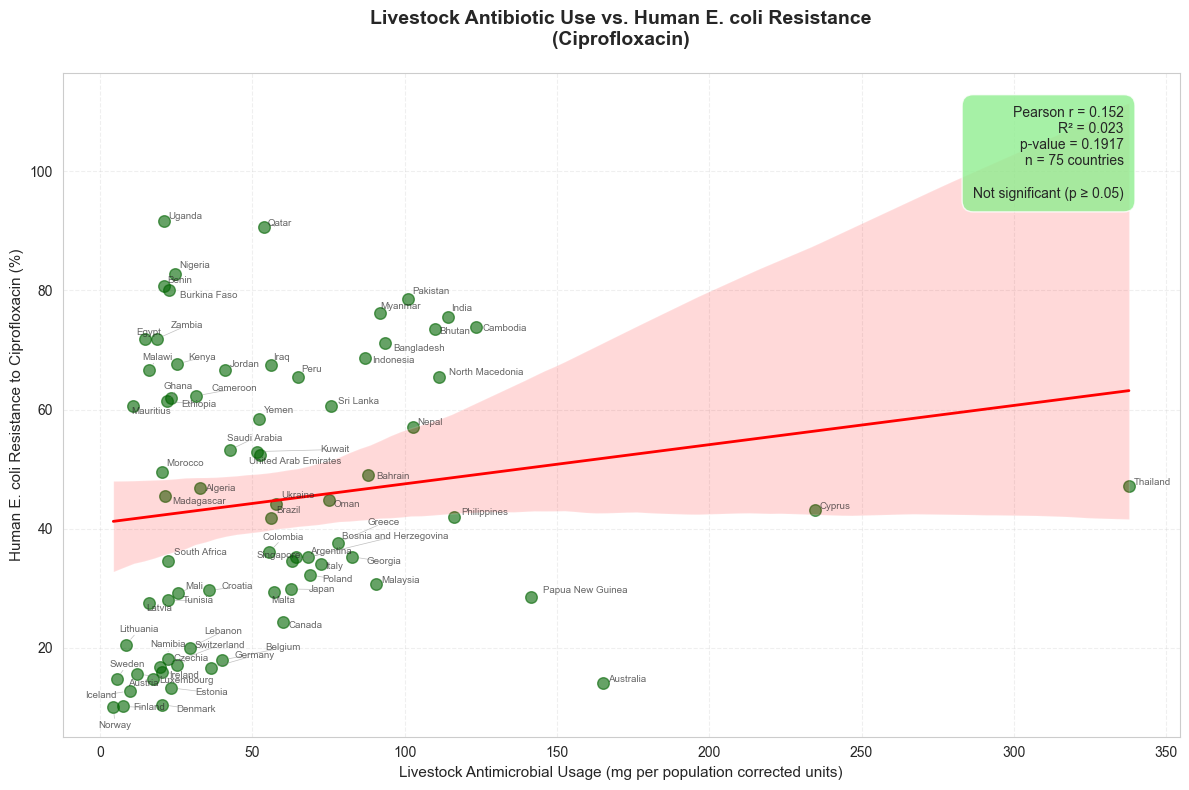

✓ Figure saved as: outputs/figures/3_livestock_vs_human_resistance.png


In [126]:
plt.figure(figsize=(12, 8))

sns.regplot(
    data=merged_livestock,
    x='Livestock_Usage',
    y='ResistancePercentage',
    scatter_kws={'s': 70, 'alpha': 0.6, 'color': 'darkgreen'},
    line_kws={'color': 'red', 'linewidth': 2}
)

# Add country labels
texts = []
for idx, row in merged_livestock.iterrows():
    text = plt.annotate(
        row['Country'],
        (row['Livestock_Usage'], row['ResistancePercentage']),
        fontsize=7,
        alpha=0.7
    )
    texts.append(text)

adjust_text(texts, 
            arrowprops=dict(arrowstyle='-', color='gray', lw=0.5, alpha=0.5, shrinkA=5, shrinkB=5),
            expand_points=(1.5, 1.5))

plt.title('Livestock Antibiotic Use vs. Human E. coli Resistance\n(Ciprofloxacin)', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Livestock Antimicrobial Usage (mg per population corrected units)', fontsize=11)
plt.ylabel('Human E. coli Resistance to Ciprofloxacin (%)', fontsize=11)
plt.grid(alpha=0.3, linestyle='--')

# Statistics box
stats_text = f"Pearson r = {r_value:.3f}\nR² = {r_squared:.3f}\np-value = {p_value:.4f}\nn = {len(merged_livestock)} countries"
if p_value < 0.05:
    stats_text += "\n\nStatistically significant"
else:
    stats_text += "\n\nNot significant (p ≥ 0.05)"

plt.text(0.95, 0.95, stats_text,
         transform=plt.gca().transAxes,
         fontsize=10,
         verticalalignment='top',
         horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8, pad=0.8))

plt.tight_layout()
plt.savefig("outputs/figures/3_livestock_vs_human_resistance.png", dpi=300, bbox_inches='tight')
plt.show()

print("✓ Figure saved as: outputs/figures/3_livestock_vs_human_resistance.png")


## 6b. Comprehensive Livestock Correlation Analysis

Analyzing the correlation between livestock antibiotic use and human E. coli resistance for **all antibiotics** in the dataset.


In [127]:
# Analyze correlation between livestock use and resistance for ALL antibiotics
livestock_correlations = []

for antibiotic in all_antibiotics:
    # Get resistance data for this antibiotic
    resistance_ab = ecoli_data[
        ecoli_data['AntibioticName'] == antibiotic
    ][['CountryTerritoryArea', 'ResistancePercentage']].copy()
    
    resistance_ab.rename(columns={'CountryTerritoryArea': 'Country'}, inplace=True)
    resistance_ab['Country'] = resistance_ab['Country'].str.strip()
    
    # Merge with livestock data
    merged = pd.merge(livestock_clean, resistance_ab, on='Country', how='inner')
    
    # Only calculate if we have enough data points
    if len(merged) >= 10:
        r_value, p_value = pearsonr(merged['Livestock_Usage'], merged['ResistancePercentage'])
        r_squared = r_value ** 2
        
        # Get the antibiotic class
        if antibiotic in antibiotic_classes:
            class_name, color = antibiotic_classes[antibiotic]
        else:
            class_name = 'Unknown'
            color = '#000000'
        
        livestock_correlations.append({
            'Antibiotic': antibiotic,
            'Class': class_name,
            'Countries': len(merged),
            'Pearson r': r_value,
            'R²': r_squared,
            'p-value': p_value,
            'Significant': 'Yes ✓' if p_value < 0.05 else 'No',
            'Avg Resistance (%)': merged['ResistancePercentage'].mean()
        })

# Create DataFrame and sort by correlation strength
livestock_corr_df = pd.DataFrame(livestock_correlations)
livestock_corr_df = livestock_corr_df.sort_values('Pearson r', ascending=False, key=abs)

# Reset index to have clean sequential numbering (1, 2, 3, ...)
livestock_corr_df = livestock_corr_df.reset_index(drop=True)
livestock_corr_df.index = livestock_corr_df.index + 1  # Start from 1 instead of 0

print(f"Livestock Antibiotic Use vs. E. coli Resistance Correlations")
print(f"{'='*80}\n")

# Display formatted table
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

livestock_corr_df


Livestock Antibiotic Use vs. E. coli Resistance Correlations



,Antibiotic,Class,Countries,Pearson r,R²,p-value,Significant,Avg Resistance (%)
1,Co-trimoxazole,Folate inhibitors,50,-0.266563,0.071056,0.061314,No,60.448961
2,Ciprofloxacin,Fluoroquinolones,75,0.152447,0.023240,0.191655,No,44.698420
3,Levofloxacin,Fluoroquinolones,42,0.149741,0.022422,0.343894,No,43.385562
4,Imipenem,Carbapenems,64,0.146397,0.021432,0.248367,No,6.549093
5,Colistin,Polymyxins,35,-0.099122,0.009825,0.571043,No,3.497500
6,Meropenem,Carbapenems,70,0.089418,0.007996,0.461652,No,6.671178
7,Third generation cephalosporins resistance,Cephalosporins (3rd gen),75,0.085431,0.007299,0.466145,No,45.542234
8,Cefotaxime,Cephalosporins (3rd gen),59,0.084888,0.007206,0.522664,No,44.254773
9,Cefepime,Cephalosporins (4th gen),57,-0.063213,0.003996,0.640400,No,36.816230
10,Ertapenem,Carbapenems,54,0.056752,0.003221,0.683559,No,7.414656


In [128]:
# Display styled table with highlighting
print("Summary Statistics:")
print(f"   • Total antibiotics analyzed: {len(livestock_corr_df)}")
print(f"   • Statistically significant correlations (p < 0.05): {(livestock_corr_df['Significant'] == 'Yes ✓').sum()}")
print(f"   • Average number of countries per analysis: {livestock_corr_df['Countries'].mean():.1f}")

# Find strongest by magnitude 
strongest_overall = livestock_corr_df.iloc[0]  # Strongest by absolute value

print(f"   • Strongest correlation (by magnitude): {strongest_overall['Antibiotic']} (r = {strongest_overall['Pearson r']:.4f})")

print("\n" + "="*80)
print("Findings:")
significant_positive = livestock_corr_df[(livestock_corr_df['Significant'] == 'Yes ✓') & (livestock_corr_df['Pearson r'] > 0)]
if len(significant_positive) > 0:
    print(f"   • {len(significant_positive)} antibiotic(s) show statistically significant POSITIVE correlations")
    print("     (higher livestock use → higher human resistance)")
    for _, row in significant_positive.iterrows():
        print(f"       - {row['Antibiotic']}: r={row['Pearson r']:.3f}, p={row['p-value']:.4f}")
else:
    print("   • No antibiotics show statistically significant positive correlations")

significant_negative = livestock_corr_df[(livestock_corr_df['Significant'] == 'Yes ✓') & (livestock_corr_df['Pearson r'] < 0)]
if len(significant_negative) > 0:
    print(f"\n   • {len(significant_negative)} antibiotic(s) show statistically significant NEGATIVE correlations")
    for _, row in significant_negative.iterrows():
        print(f"       - {row['Antibiotic']}: r={row['Pearson r']:.3f}, p={row['p-value']:.4f}")

# Create a nicely formatted display table
display_df = livestock_corr_df.copy()
display_df['Pearson r'] = display_df['Pearson r'].apply(lambda x: f"{x:.3f}")
display_df['R²'] = display_df['R²'].apply(lambda x: f"{x:.3f}")
display_df['p-value'] = display_df['p-value'].apply(lambda x: f"{x:.4f}")
display_df['Avg Resistance (%)'] = display_df['Avg Resistance (%)'].apply(lambda x: f"{x:.1f}")

print("\n" + "="*80)
print("Correlation Table:")
print("(Ranked by absolute correlation strength)\n")
display_df


Summary Statistics:
   • Total antibiotics analyzed: 12
   • Statistically significant correlations (p < 0.05): 0
   • Average number of countries per analysis: 59.2
   • Strongest correlation (by magnitude): Co-trimoxazole (r = -0.2666)

Findings:
   • No antibiotics show statistically significant positive correlations

Correlation Table:
(Ranked by absolute correlation strength)



,Antibiotic,Class,Countries,Pearson r,R²,p-value,Significant,Avg Resistance (%)
1,Co-trimoxazole,Folate inhibitors,50,-0.267,0.071,0.0613,No,60.4
2,Ciprofloxacin,Fluoroquinolones,75,0.152,0.023,0.1917,No,44.7
3,Levofloxacin,Fluoroquinolones,42,0.150,0.022,0.3439,No,43.4
4,Imipenem,Carbapenems,64,0.146,0.021,0.2484,No,6.5
5,Colistin,Polymyxins,35,-0.099,0.010,0.5710,No,3.5
6,Meropenem,Carbapenems,70,0.089,0.008,0.4617,No,6.7
7,Third generation cephalosporins resistance,Cephalosporins (3rd gen),75,0.085,0.007,0.4661,No,45.5
8,Cefotaxime,Cephalosporins (3rd gen),59,0.085,0.007,0.5227,No,44.3
9,Cefepime,Cephalosporins (4th gen),57,-0.063,0.004,0.6404,No,36.8
10,Ertapenem,Carbapenems,54,0.057,0.003,0.6836,No,7.4
